In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import gc
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from random import shuffle
from scipy.stats import spearmanr

from access_biology_data import lincs, properties
from access_science_shared import standardizer

sys.path.append('./../src/')
from aging_tools import inout, export

from access_biology_data import annotation
from access_biology_data import meta

In [4]:
outfolder = '190428_gtex_transcript_imbalance'

In [5]:
save_images = True

In [6]:
ref_genes = standardizer.reference_genes(9606, 'orp')

/Users/tstoeger/anaconda3/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [7]:
import glob

In [8]:
p =export.get_material_path(
    '190428_chache_tstoeger_190427_gtex_with_tilt/stats_on_imbalance.xlsx')

In [9]:
d = pd.read_excel(p)

In [10]:
d.head()

,condition,tilt,pval,tilt_orp,pval_orp,gender,tissue,younger,older
0,females_Adipose_Subcutaneous_3_vs_2,0.210298,2.384289e-172,0.212675,1.699691e-175,female,Adipose - Subcutaneous,2,3
1,females_Adipose_Subcutaneous_4_vs_2,0.146914,2.880636e-84,0.147476,1.654229e-84,female,Adipose - Subcutaneous,2,4
2,females_Adipose_Subcutaneous_4_vs_3,-0.115481,1.456786e-52,-0.117334,5.719052e-54,female,Adipose - Subcutaneous,3,4
3,females_Adipose_Subcutaneous_5_vs_2,0.071833,2.592071e-21,0.072112,2.264565e-21,female,Adipose - Subcutaneous,2,5
4,females_Adipose_Subcutaneous_5_vs_3,-0.180310,6.988833e-127,-0.182700,1.148451e-129,female,Adipose - Subcutaneous,3,5


In [11]:
d = d.rename(columns={'tilt': 'rho', 'tissue': 'region'})

In [12]:
d['gender'] = d['gender'] + 's'

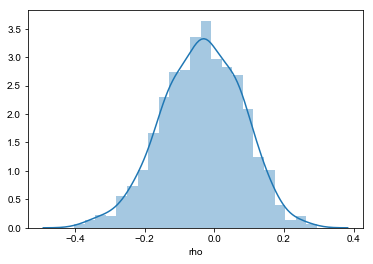

In [13]:
sns.distplot(d['rho'])

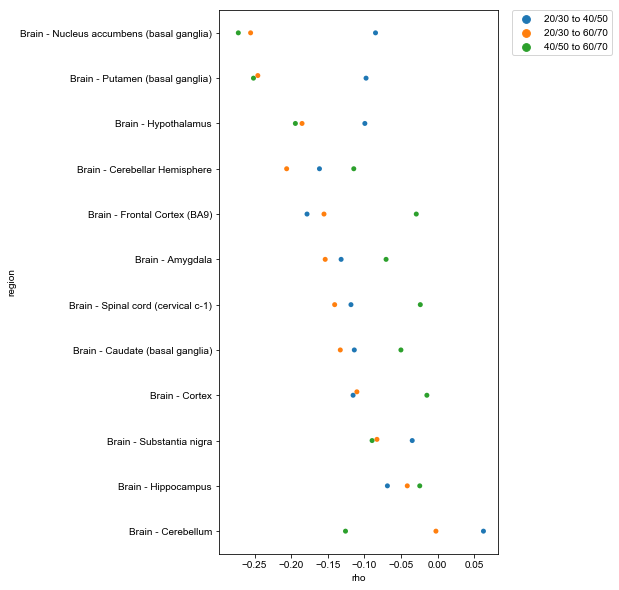

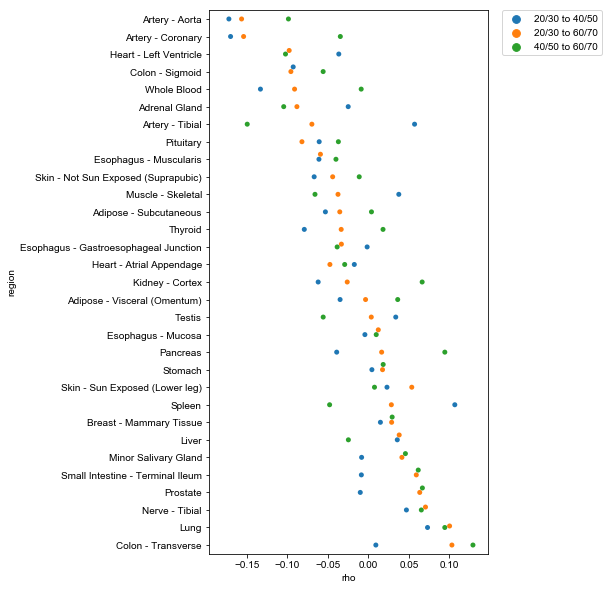

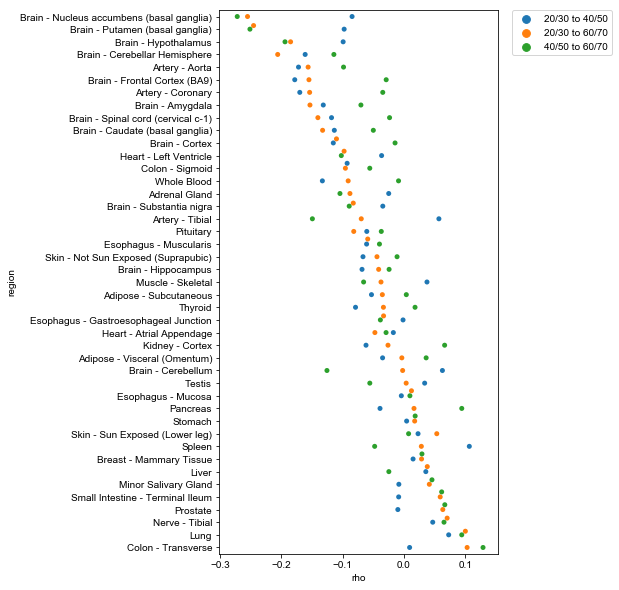

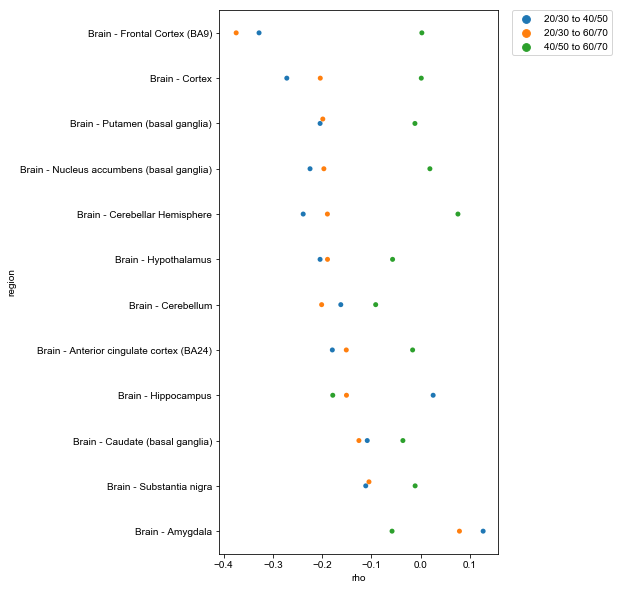

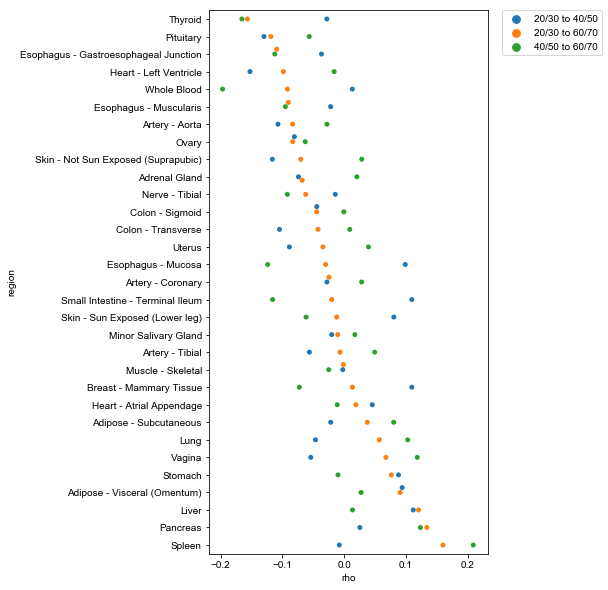

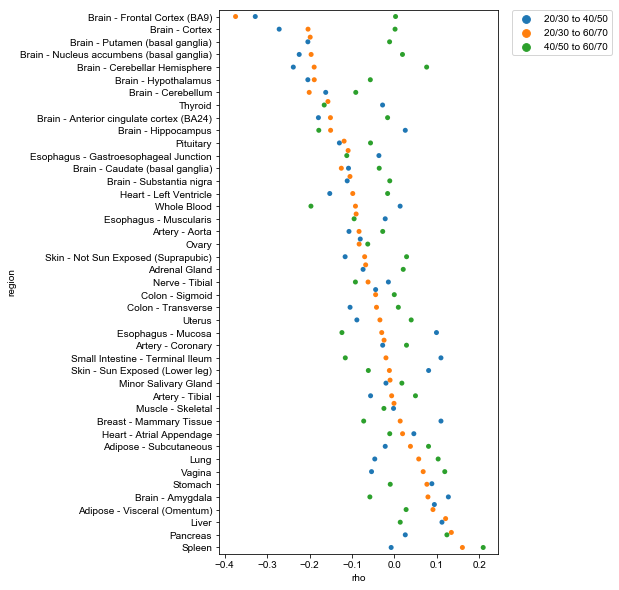

In [14]:
agg = []

for gender in ['males', 'females']:

    s = d[(d['gender']==gender)].copy()

    f = (s['younger'].isin([2, 3]) & s['older'].isin([4, 5]))
    s.loc[f, 'cat'] = '20/30 to 40/50'

    f = (s['younger'].isin([4, 5]) & s['older'].isin([6, 7]))
    s.loc[f, 'cat'] = '40/50 to 60/70'

    f = (s['younger'].isin([2, 3]) & s['older'].isin([6, 7]))
    s.loc[f, 'cat'] = '20/30 to 60/70'

    s = s.dropna(subset=['cat'])

    s = s[['pval', 'region', 'cat', 'rho']].groupby(['region', 'cat']).agg(np.median)

    s = s.reset_index()
    comparisons_per_tissue = s['region'].value_counts()
    
    # only consider, if all thre age comparisons are there
    s = s[s['region'].isin(comparisons_per_tissue[comparisons_per_tissue==3].index)]

    order = s[['region', 'rho']].groupby('region').agg(np.median).sort_values('rho')

    hue_order=['20/30 to 40/50','20/30 to 60/70', '40/50 to 60/70', ]

    plt.figure(figsize=(5, 10))
    sns.swarmplot(x='rho', y='region',data=s, hue='cat',
                order=order[order.index.str.startswith('Brain')].index,
                hue_order=hue_order
                 )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if save_images:
        export.export_image(
            '{}/{}_brain.pdf'.format(
                outfolder,
                gender))

    plt.figure(figsize=(5, 10))
    sns.swarmplot(x='rho', y='region',data=s, hue='cat',
                order=order[~order.index.str.startswith('Brain')].index,
                hue_order=hue_order
                 )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if save_images:
        export.export_image(
            '{}/{}_non_brain.pdf'.format(
                outfolder,
                gender))

    plt.figure(figsize=(5, 10))
    sns.swarmplot(x='rho', y='region',data=s, hue='cat',
                order=order.index,
                hue_order=hue_order
                 )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if save_images:
        export.export_image(
            '{}/{}_all.pdf'.format(
                outfolder,
                gender))
        
    if save_images:
        export.export_full_frame(
            '{}/{}_all.xlsx'.format(
                    outfolder,
                    gender), 
            s)
        
        export.export_full_frame(
            '{}/{}_young_to_old.xlsx'.format(
                    outfolder,
                    gender), 
            s[s['cat']=='20/30 to 60/70'])  
        
    s.loc[:, 'gender'] = gender
    agg.append(s)

In [15]:
d['younger'].value_counts()

2    375
3    285
4    247
5    158
6     70
Name: younger, dtype: int64

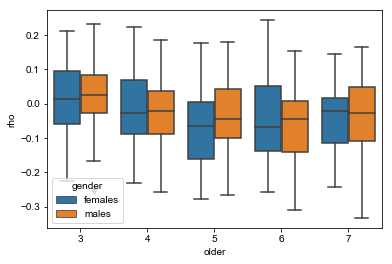

In [16]:
sns.boxplot(
    x='older',
    y='rho',
    data=d[d['younger']==2],
    hue='gender'

)

In [17]:
e = pd.concat(agg)

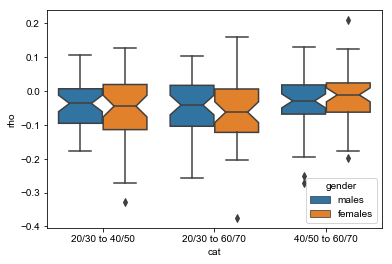

In [18]:
sns.boxplot(x='cat', y='rho', data=e, hue='gender', notch=True)

if save_images:
    export.export_image(
        '{}/notched_box_by_third.pdf'.format(
            outfolder))

In [19]:
f = e['region'].str.startswith('Brain -')

In [20]:
e.loc[:, 'is_brain'] = f.astype(float)

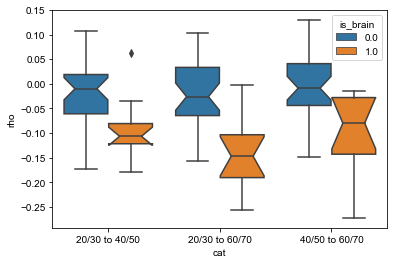

In [21]:
sns.boxplot(x='cat', y='rho', data=e[e['gender']=='males'], hue='is_brain', notch=True)

if save_images:
    export.export_image(
        '{}/notched_box_by_male_brain.pdf'.format(
            outfolder))

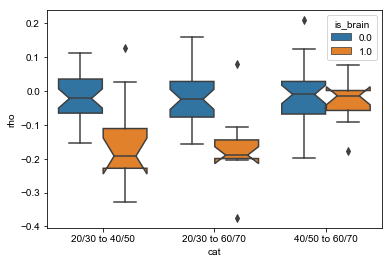

In [22]:
sns.boxplot(x='cat', y='rho', data=e[e['gender']=='females'], hue='is_brain', notch=True)

if save_images:
    export.export_image(
        '{}/notched_box_by_female_brain.pdf'.format(
            outfolder))

In [23]:
e

,region,cat,pval,rho,gender,is_brain
0,Adipose - Subcutaneous,20/30 to 40/50,1.543676e-06,-0.053026,males,0.0
1,Adipose - Subcutaneous,20/30 to 60/70,1.301222e-05,-0.035287,males,0.0
2,Adipose - Subcutaneous,40/50 to 60/70,6.025473e-02,0.003837,males,0.0
3,Adipose - Visceral (Omentum),20/30 to 40/50,1.776942e-03,-0.034899,males,0.0
4,Adipose - Visceral (Omentum),20/30 to 60/70,5.838490e-01,-0.003455,males,0.0
...,...,...,...,...,...,...
125,Vagina,20/30 to 60/70,3.593140e-14,0.067668,females,0.0
126,Vagina,40/50 to 60/70,5.966848e-31,0.118560,females,0.0
127,Whole Blood,20/30 to 40/50,2.318563e-07,0.013320,females,0.0
128,Whole Blood,20/30 to 60/70,1.081946e-21,-0.091987,females,0.0


In [24]:
m = e[e['gender']=='males']
m_rho = m.pivot(index='region', columns='cat', values='rho').reindex(
    columns=['20/30 to 40/50', '20/30 to 60/70']
)
m_pval = m.pivot(index='region', columns='cat', values='pval').reindex(
    columns=['20/30 to 40/50', '20/30 to 60/70']
)

In [25]:
if save_images:
    export.export_full_frame(
        '{}/table_imbalance_male.xlsx'.format(outfolder),
        m_rho)
    
    export.export_full_frame(
        '{}/table_pval_male.xlsx'.format(outfolder),
        m_pval)

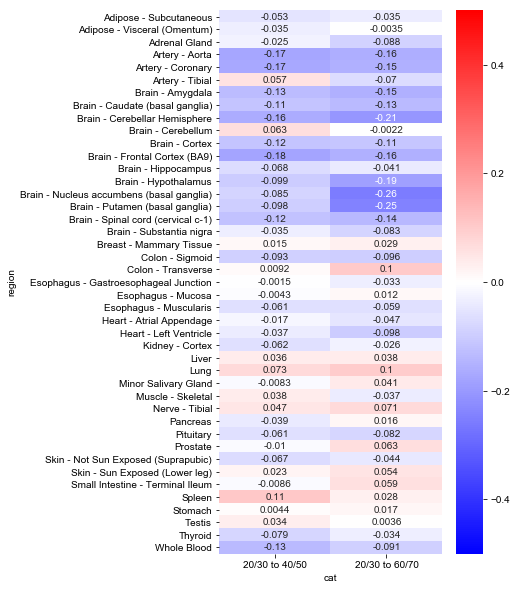

In [26]:
plt.figure(figsize=(5, 10))
sns.heatmap(m_rho, vmin=-0.5, vmax=0.5, cmap='bwr', annot=True)

if save_images:
    export.export_image(
        '{}/table_imbalance_male.pdf'.format(
            outfolder))

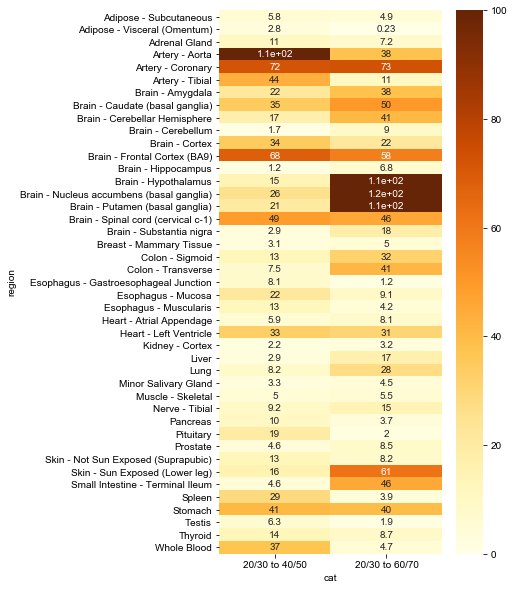

In [27]:
plt.figure(figsize=(5, 10))
sns.heatmap(m_pval.apply(lambda x: -np.log10(x)), annot=True, vmin=0, vmax=100, cmap='YlOrBr')


if save_images:
    export.export_image(
        '{}/table_pval_male.pdf'.format(
            outfolder))

In [28]:
m = e[e['gender']=='females']
m_rho = m.pivot(index='region', columns='cat', values='rho').reindex(
    columns=['20/30 to 40/50', '20/30 to 60/70']
)
m_pval = m.pivot(index='region', columns='cat', values='pval').reindex(
    columns=['20/30 to 40/50', '20/30 to 60/70']
)

In [29]:
if save_images:
    export.export_full_frame(
        '{}/table_imbalance_female.xlsx'.format(outfolder),
        m_rho)
    
    export.export_full_frame(
        '{}/table_pval_female.xlsx'.format(outfolder),
        m_pval)

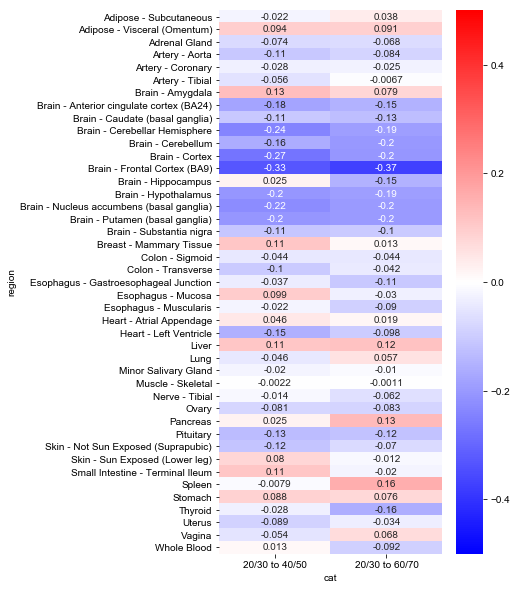

In [30]:
plt.figure(figsize=(5, 10))
sns.heatmap(m_rho, vmin=-0.5, vmax=0.5, cmap='bwr', annot=True)

if save_images:
    export.export_image(
        '{}/table_imbalance_female.pdf'.format(
            outfolder))

In [31]:
if save_images:
    export.export_image(
        '{}/table_pval_female.pdf'.format(
            outfolder))

<Figure size 432x288 with 0 Axes>

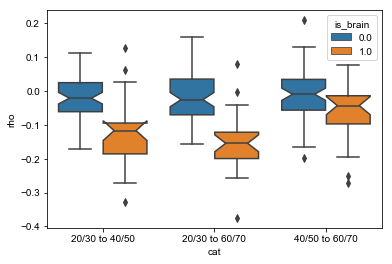

In [32]:
sns.boxplot(x='cat', y='rho', data=e, hue='is_brain', notch=True)

if save_images:
    export.export_image(
        '{}/notched_box_by_brain.pdf'.format(
            outfolder))

In [33]:
if save_images:
    export.export_full_frame(
        '{}/summary_stats.xlsx'.format(outfolder), e)

In [34]:
from scipy.stats import mannwhitneyu

In [35]:
def comp(t):
    a = t[t['cat']=='20/30 to 40/50']['rho']
    b = t[t['cat']=='20/30 to 60/70']['rho']
    
    _, p = mannwhitneyu(a, b, alternative='two-sided')
    print(p)
    return

In [36]:
comp(e[e['is_brain']==True])

0.2790163132113638


In [37]:
comp(e[(e['is_brain']==True) & (e['gender']=='males')])

0.11235119769046395


In [38]:
comp(e[(e['is_brain']==True) & (e['gender']=='females')])

0.623604884395689


In [39]:
d.loc[:, 'is_brain'] = d.loc[:, 'region'].str.startswith('Brain_') == True

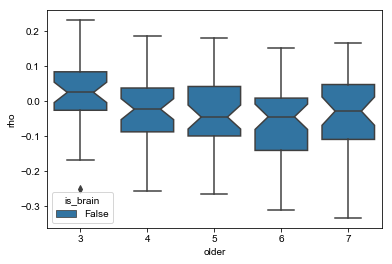

In [40]:
sns.boxplot(
    x='older',
    y='rho',
    data=d[(d['younger'].isin([2])) & (d['gender']=='males')],
    hue='is_brain',
    notch=True
)



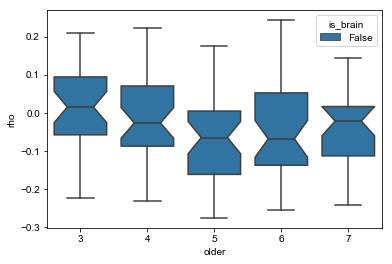

In [41]:
sns.boxplot(
    x='older',
    y='rho',
    data=d[(d['younger'].isin([2])) & (d['gender']=='females')],
    hue='is_brain',
    notch=True
)



In [42]:
def comp(t, s):
    a = t[(t['cat']==s) & (t['is_brain']==True)]['rho']
    b = t[(t['cat']==s) & (t['is_brain']==False)]['rho']
    
    _, p = mannwhitneyu(a, b, alternative='two-sided')
    print(p)
    return

In [43]:
comp(e, '20/30 to 40/50')

3.901600836744818e-06


In [44]:
comp(e, '20/30 to 60/70')

1.9334458475947866e-08
